# Visualize Amazon Customer Reviews Dataset
For this notebook, we will query a subset of reviews for the Digital Software, Digital Video Games, and Gift Card product categories.  We will also show the results for the entire dataset.

# Dataset Column Descriptions

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.
- `year`: The year derived from the review date.

In [1]:
import sagemaker
import boto3

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
%store -r ingest_create_athena_table_parquet_passed

In [4]:
try:
    ingest_create_athena_table_parquet_passed
except NameError:
    print("++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL PREVIOUS NOTEBOOKS")
    print("You did not convert into Parquet data.        ")
    print("++++++++++++++++++++++++++++++++++++++++++++++")

In [5]:
print(ingest_create_athena_table_parquet_passed)

True


In [6]:
if not ingest_create_athena_table_parquet_passed:
    print("++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL PREVIOUS NOTEBOOKS")
    print("You did not convert into Parquet data.        ")
    print("++++++++++++++++++++++++++++++++++++++++++++++")
else:
    print("[OK]")

[OK]


In [7]:
database_name = "default"
table_name = "amazon_reviews_parquet"

In [8]:
from pyathena import connect

In [9]:
s3_staging_dir = "s3://{}/athena/query-cache".format(bucket)

In [10]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

# Set Seaborn Parameters

In [11]:
sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

# Helper Code to Display Values on Bars

In [12]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()), 2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

# 1. Which Product Categories are Highest Rated by Average Rating?

In [13]:
%%time

# SQL statement
statement = """
    SELECT product_category, AVG(star_rating) AS avg_star_rating
    FROM {}.{} 
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    GROUP BY product_category 
    ORDER BY avg_star_rating DESC
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df.head(5)


    SELECT product_category, AVG(star_rating) AS avg_star_rating
    FROM default.amazon_reviews_parquet 
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    GROUP BY product_category 
    ORDER BY avg_star_rating DESC

CPU times: user 136 ms, sys: 24.6 ms, total: 161 ms
Wall time: 3.44 s


,product_category,avg_star_rating
0,Gift_Card,4.731363
1,Digital_Video_Games,3.853126
2,Digital_Software,3.539330


In [14]:
# Store number of categories
num_categories = df.shape[0]
print(num_categories)

# Store average star ratings
average_star_ratings = df

3


## Visualization for a Subset of Product Categories

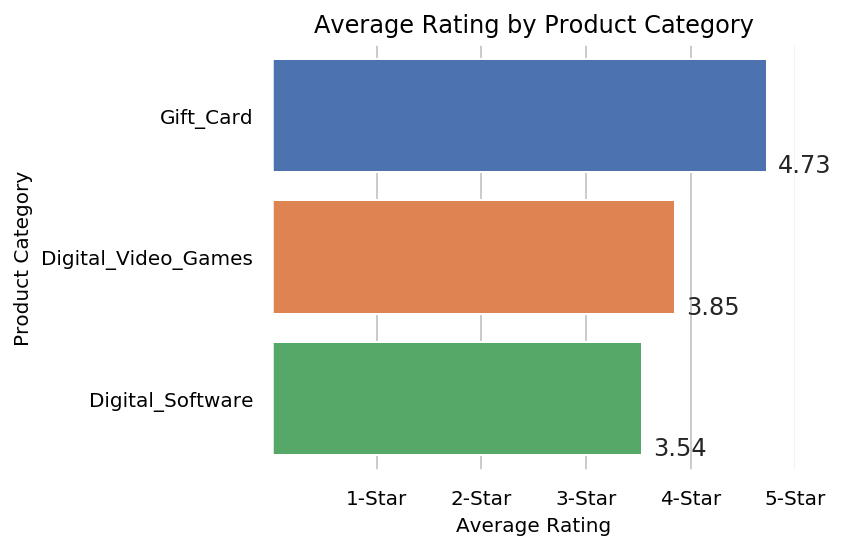

In [15]:
# Create plot
barplot = sns.barplot(y="product_category", x="avg_star_rating", data=df, saturation=1)

if num_categories < 10:
    sns.set(rc={"figure.figsize": (10.0, 5.0)})

# Set title and x-axis ticks
plt.title("Average Rating by Product Category")
plt.xticks([1, 2, 3, 4, 5], ["1-Star", "2-Star", "3-Star", "4-Star", "5-Star"])

# Helper code to show actual values afters bars
show_values_barplot(barplot, 0.1)

plt.xlabel("Average Rating")
plt.ylabel("Product Category")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-01.png"  width="80%" align="left">

# 2. Which Product Categories Have the Most Reviews?

In [16]:
# SQL statement
statement = """
    SELECT product_category, COUNT(star_rating) AS count_star_rating 
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY product_category 
    ORDER BY count_star_rating DESC
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df.head()


    SELECT product_category, COUNT(star_rating) AS count_star_rating 
    FROM default.amazon_reviews_parquet
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY product_category 
    ORDER BY count_star_rating DESC



,product_category,count_star_rating
0,Gift_Card,149086
1,Digital_Video_Games,145431
2,Digital_Software,102084


In [17]:
# Store counts
count_ratings = df["count_star_rating"]

# Store max ratings
max_ratings = df["count_star_rating"].max()
print(max_ratings)

149086


## Visualization for a Subset of Product Categories

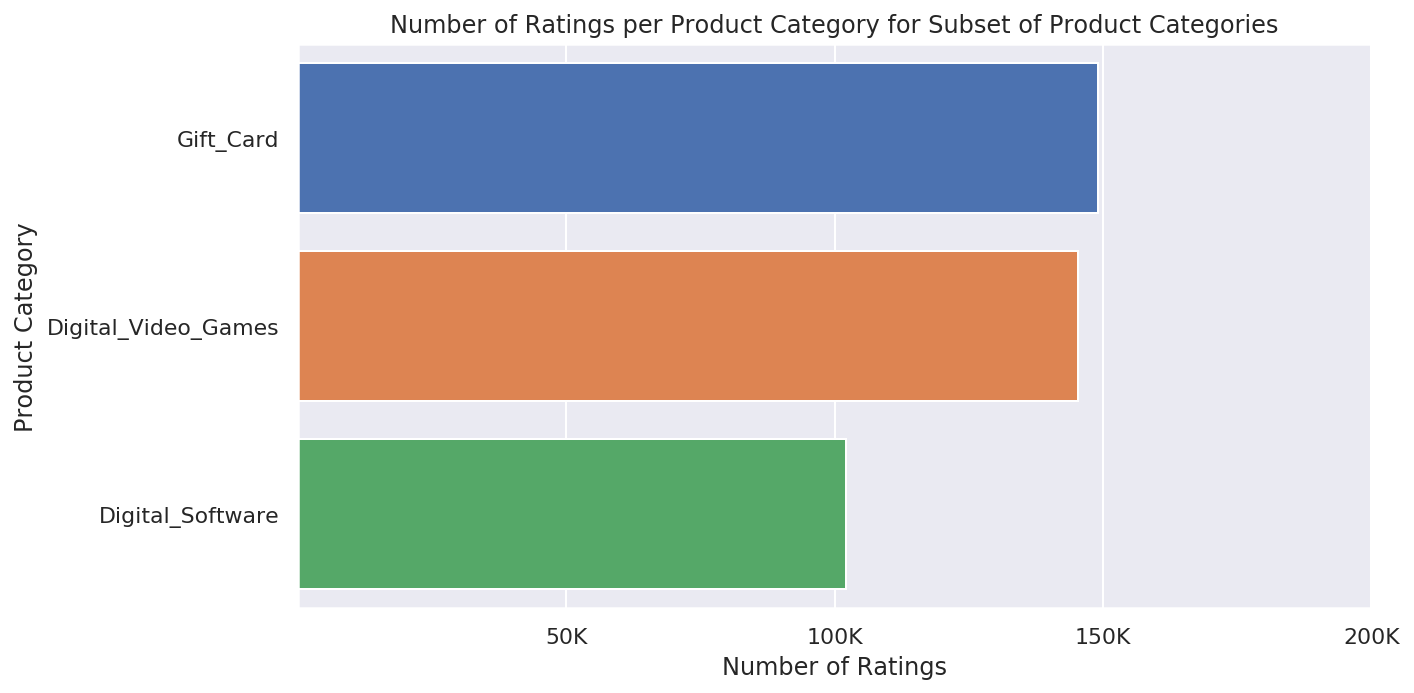

In [18]:
# Create Seaborn barplot
barplot = sns.barplot(y="product_category", x="count_star_rating", data=df, saturation=1)

if num_categories < 10:
    sns.set(rc={"figure.figsize": (10.0, 5.0)})

# Set title
plt.title("Number of Ratings per Product Category for Subset of Product Categories")

# Set x-axis ticks to match scale
if max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ["100K", "1m", "5m", "10m", "15m", "20m"])
    plt.xlim(0, 20000000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ["50K", "100K", "150K", "200K"])
    plt.xlim(0, 200000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-02.png"  width="80%" align="left">

# 3. When did each product category become available in the Amazon catalog based on the date of the first review?

In [19]:
# SQL statement
statement = """
    SELECT product_category, MIN(year) AS first_review_year
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY product_category
    ORDER BY first_review_year 
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df.head()


    SELECT product_category, MIN(year) AS first_review_year
    FROM default.amazon_reviews_parquet
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY product_category
    ORDER BY first_review_year 



,product_category,first_review_year
0,Gift_Card,2004
1,Digital_Video_Games,2006
2,Digital_Software,2008


In [20]:
def get_x_y(df):
    """ Get X and Y coordinates; return tuple """
    series = df["first_review_year"].value_counts().sort_index()
    # new_series = series.reindex(range(1,21)).fillna(0).astype(int)
    return series.index, series.values

In [21]:
X, Y = get_x_y(df)

## Visualization for a Subset of Product Categories

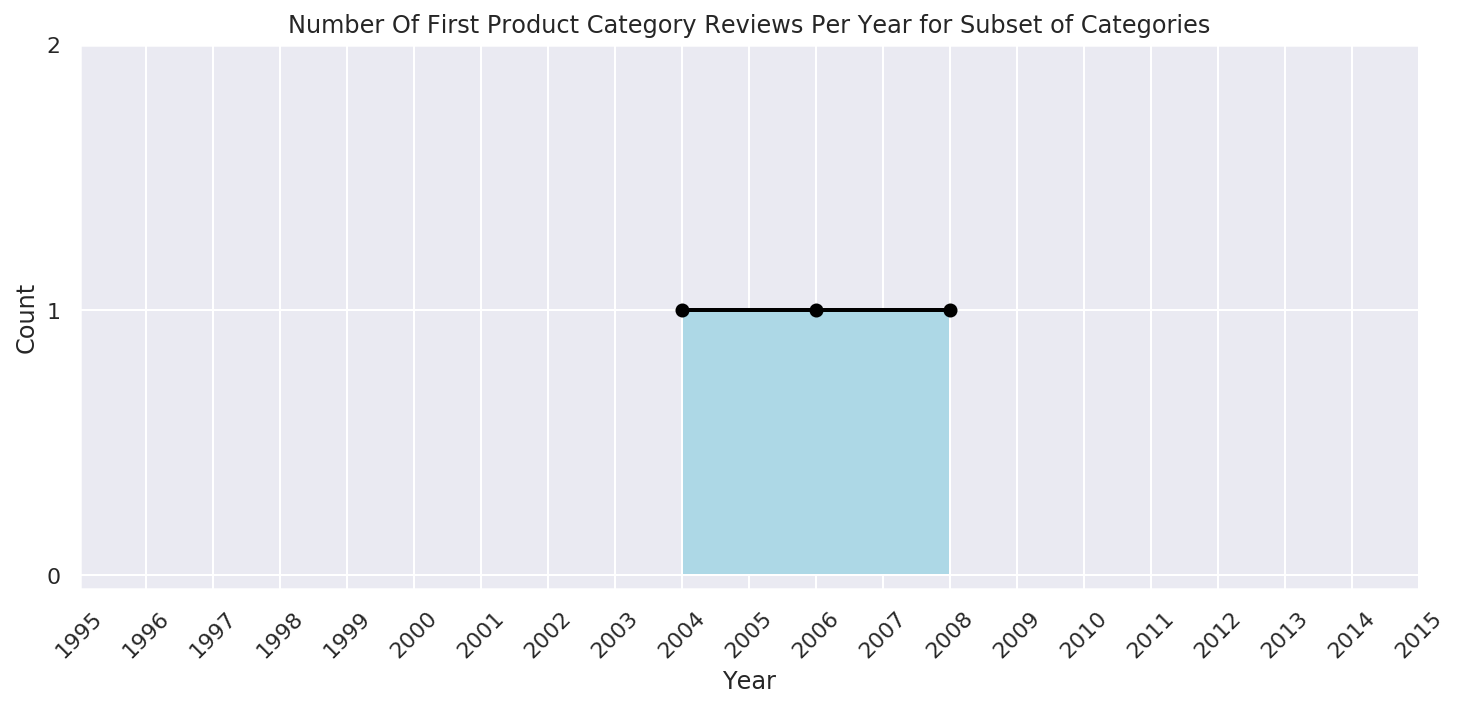

In [22]:
fig = plt.figure(figsize=(12, 5))
ax = plt.gca()

ax.set_title("Number Of First Product Category Reviews Per Year for Subset of Categories")
ax.set_xlabel("Year")
ax.set_ylabel("Count")

ax.plot(X, Y, color="black", linewidth=2, marker="o")
ax.fill_between(X, [0] * len(X), Y, facecolor="lightblue")

ax.locator_params(integer=True)

ax.set_xticks(range(1995, 2016, 1))
ax.set_yticks(range(0, max(Y) + 2, 1))

plt.xticks(rotation=45)

# fig.savefig('first_reviews_per_year.png', dpi=300)
plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-04.png"  width="90%" align="left">

# 4. What is the breakdown of ratings (1-5) per product category?  


In [23]:
# SQL statement
statement = """
    SELECT product_category, star_rating, COUNT(*) AS count_reviews
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY  product_category, star_rating
    ORDER BY  product_category ASC, star_rating DESC, count_reviews
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df


    SELECT product_category, star_rating, COUNT(*) AS count_reviews
    FROM default.amazon_reviews_parquet
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY  product_category, star_rating
    ORDER BY  product_category ASC, star_rating DESC, count_reviews



,product_category,star_rating,count_reviews
0,Digital_Software,5,46410
1,Digital_Software,4,16693
2,Digital_Software,3,8308
3,Digital_Software,2,6890
4,Digital_Software,1,23783
5,Digital_Video_Games,5,80677
6,Digital_Video_Games,4,20406
7,Digital_Video_Games,3,11629
8,Digital_Video_Games,2,7749
9,Digital_Video_Games,1,24970


## Prepare for Stacked Percentage Horizontal Bar Plot Showing Proportion of Star Ratings per Product Category

In [24]:
# Create grouped DataFrames by category and by star rating
grouped_category = df.groupby("product_category")
grouped_star = df.groupby("star_rating")

# Create sum of ratings per star rating
df_sum = df.groupby(["star_rating"]).sum()

# Calculate total number of star ratings
total = df_sum["count_reviews"].sum()
print(total)

396601


In [25]:
# Create dictionary of product categories and array of star rating distribution per category
distribution = {}
count_reviews_per_star = []
i = 0

for category, ratings in grouped_category:
    count_reviews_per_star = []
    for star in ratings["star_rating"]:
        count_reviews_per_star.append(ratings.at[i, "count_reviews"])
        i = i + 1
    distribution[category] = count_reviews_per_star

# Check if distribution has been created succesfully
print(distribution)

{'Digital_Software': [46410, 16693, 8308, 6890, 23783], 'Digital_Video_Games': [80677, 20406, 11629, 7749, 24970], 'Gift_Card': [129709, 9859, 3156, 1569, 4793]}


In [26]:
# Check if distribution keys are set correctly to product categories
print(distribution.keys())

dict_keys(['Digital_Software', 'Digital_Video_Games', 'Gift_Card'])


In [27]:
# Check if star rating distributions are set correctly
print(distribution.items())

dict_items([('Digital_Software', [46410, 16693, 8308, 6890, 23783]), ('Digital_Video_Games', [80677, 20406, 11629, 7749, 24970]), ('Gift_Card', [129709, 9859, 3156, 1569, 4793])])


### Build Array per Star Across All Categories

In [28]:
# Sort distribution by highest average rating per category
sorted_distribution = {}

average_star_ratings.iloc[:, 0]
for index, value in average_star_ratings.iloc[:, 0].items():
    sorted_distribution[value] = distribution[value]

In [29]:
sorted_distribution

{'Gift_Card': [129709, 9859, 3156, 1569, 4793],
 'Digital_Video_Games': [80677, 20406, 11629, 7749, 24970],
 'Digital_Software': [46410, 16693, 8308, 6890, 23783]}

In [30]:
# Build array per star across all categories
star1 = []
star2 = []
star3 = []
star4 = []
star5 = []

for k in sorted_distribution.keys():
    stars = sorted_distribution.get(k)
    star5.append(stars[0])
    star4.append(stars[1])
    star3.append(stars[2])
    star2.append(stars[3])
    star1.append(stars[4])

## Visualization for a Subset of Product Categories

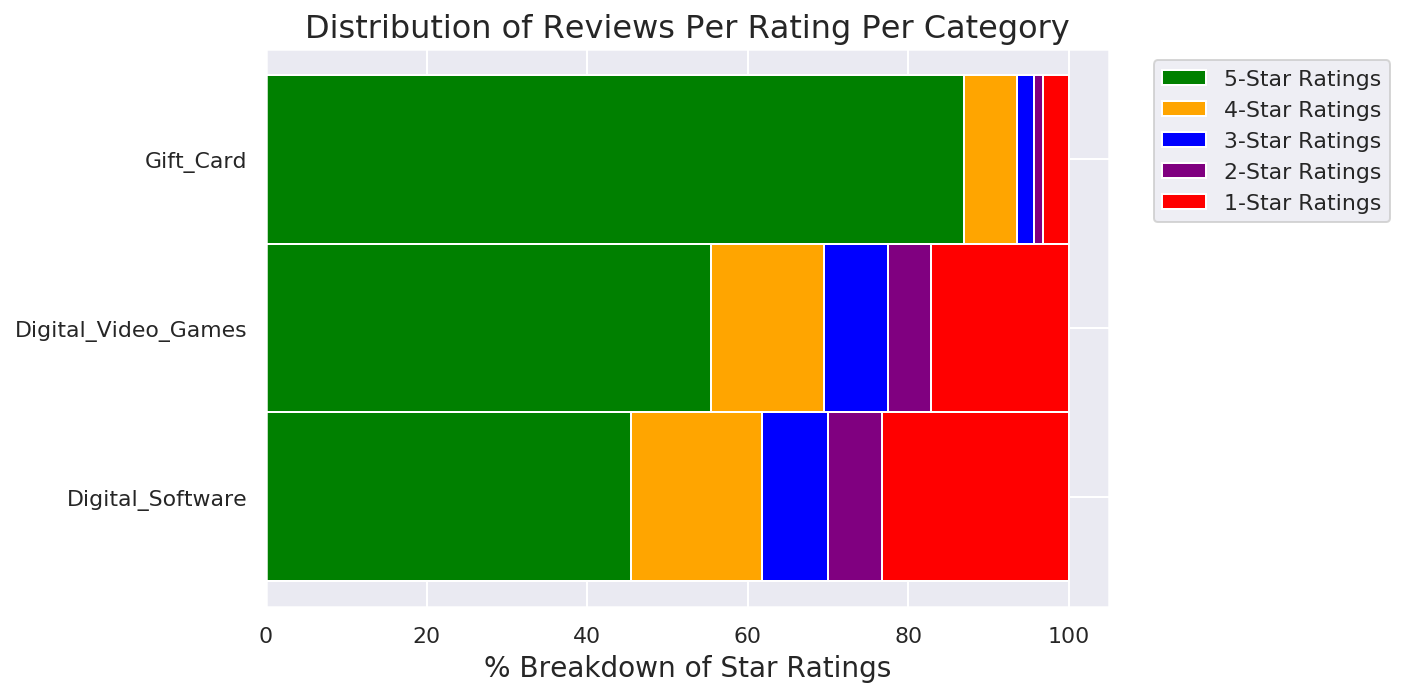

In [31]:
# Plot the distributions of star ratings per product category

categories = sorted_distribution.keys()

total = np.array(star1) + np.array(star2) + np.array(star3) + np.array(star4) + np.array(star5)

proportion_star1 = np.true_divide(star1, total) * 100
proportion_star2 = np.true_divide(star2, total) * 100
proportion_star3 = np.true_divide(star3, total) * 100
proportion_star4 = np.true_divide(star4, total) * 100
proportion_star5 = np.true_divide(star5, total) * 100

# Add colors
colors = ["red", "purple", "blue", "orange", "green"]

# The position of the bars on the x-axis
r = range(len(categories))
barHeight = 1

# Plot bars
if num_categories > 10:
    plt.figure(figsize=(10, 10))
else:
    plt.figure(figsize=(10, 5))

ax5 = plt.barh(r, proportion_star5, color=colors[4], edgecolor="white", height=barHeight, label="5-Star Ratings")
ax4 = plt.barh(
    r,
    proportion_star4,
    left=proportion_star5,
    color=colors[3],
    edgecolor="white",
    height=barHeight,
    label="4-Star Ratings",
)
ax3 = plt.barh(
    r,
    proportion_star3,
    left=proportion_star5 + proportion_star4,
    color=colors[2],
    edgecolor="white",
    height=barHeight,
    label="3-Star Ratings",
)
ax2 = plt.barh(
    r,
    proportion_star2,
    left=proportion_star5 + proportion_star4 + proportion_star3,
    color=colors[1],
    edgecolor="white",
    height=barHeight,
    label="2-Star Ratings",
)
ax1 = plt.barh(
    r,
    proportion_star1,
    left=proportion_star5 + proportion_star4 + proportion_star3 + proportion_star2,
    color=colors[0],
    edgecolor="white",
    height=barHeight,
    label="1-Star Ratings",
)

plt.title("Distribution of Reviews Per Rating Per Category", fontsize="16")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.yticks(r, categories, fontweight="regular")

plt.xlabel("% Breakdown of Star Ratings", fontsize="14")
plt.gca().invert_yaxis()
plt.tight_layout()

# plt.savefig('proportion_star_per_category.png', dpi=300)
plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-05.png"  width="80%" align="left">

# 5. How Many Reviews per Star Rating? (5, 4, 3, 2, 1) 

In [32]:
# SQL statement
statement = """
    SELECT star_rating, COUNT(*) AS count_reviews
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    GROUP BY star_rating
    ORDER BY star_rating DESC, count_reviews 
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df


    SELECT star_rating, COUNT(*) AS count_reviews
    FROM default.amazon_reviews_parquet
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    GROUP BY star_rating
    ORDER BY star_rating DESC, count_reviews 



,star_rating,count_reviews
0,5,256796
1,4,46958
2,3,23093
3,2,16208
4,1,53546


## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/star_rating_count_all.png"  width="25%" align="left">

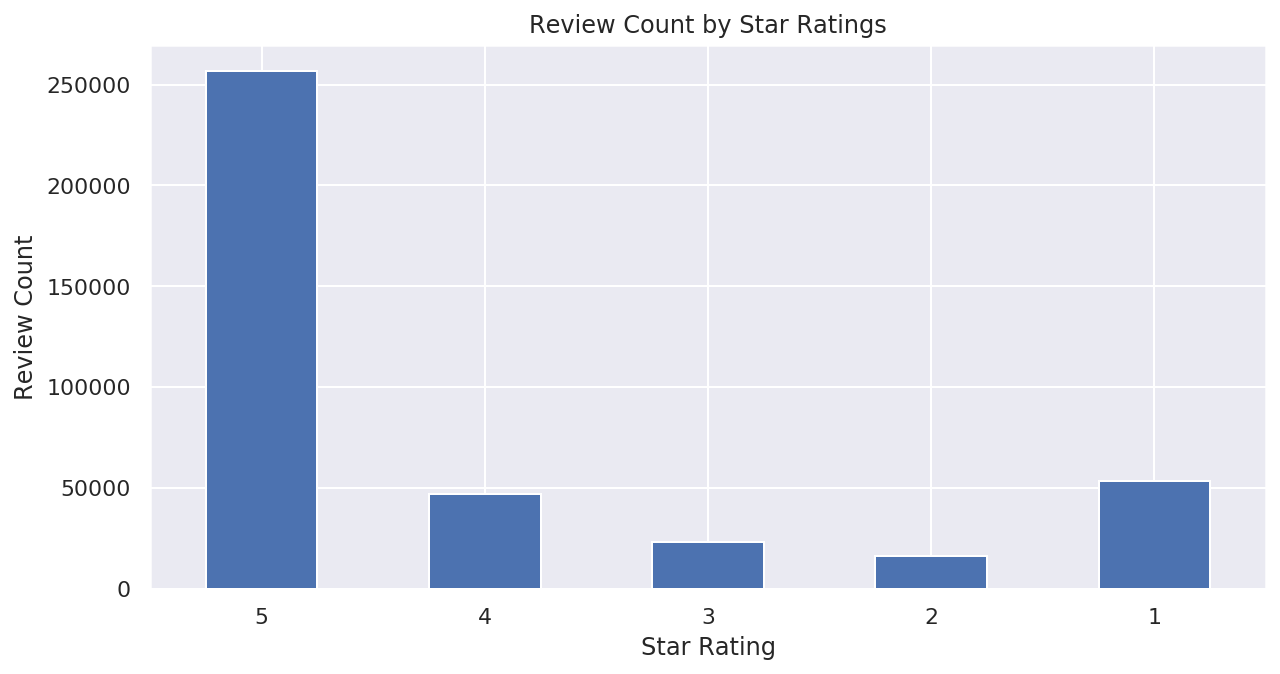

In [33]:
chart = df.plot.bar(
    x="star_rating", y="count_reviews", rot="0", figsize=(10, 5), title="Review Count by Star Ratings", legend=False
)

plt.xlabel("Star Rating")
plt.ylabel("Review Count")

plt.show(chart)

## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:


<img src="img/star_rating_count_all_bar_chart.png"  width="60%" align="left">

# 6. How Did Star Ratings Change Over Time?
Is there a drop-off point for certain product categories throughout the year?

## Average Star Rating Across All Product Categories

In [34]:
# SQL statement
statement = """
    SELECT year, ROUND(AVG(star_rating),4) AS avg_rating
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY year
    ORDER BY year
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df


    SELECT year, ROUND(AVG(star_rating),4) AS avg_rating
    FROM default.amazon_reviews_parquet
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY year
    ORDER BY year



,year,avg_rating
0,2004,4.5000
1,2005,3.2759
2,2006,3.3750
3,2007,3.9500
4,2008,2.8966
5,2009,3.7288
6,2010,3.7614
7,2011,3.9808
8,2012,4.0955
9,2013,4.0080


In [35]:
df["year"] = pd.to_datetime(df["year"], format="%Y").dt.year

## Visualization for a Subset of Product Categories

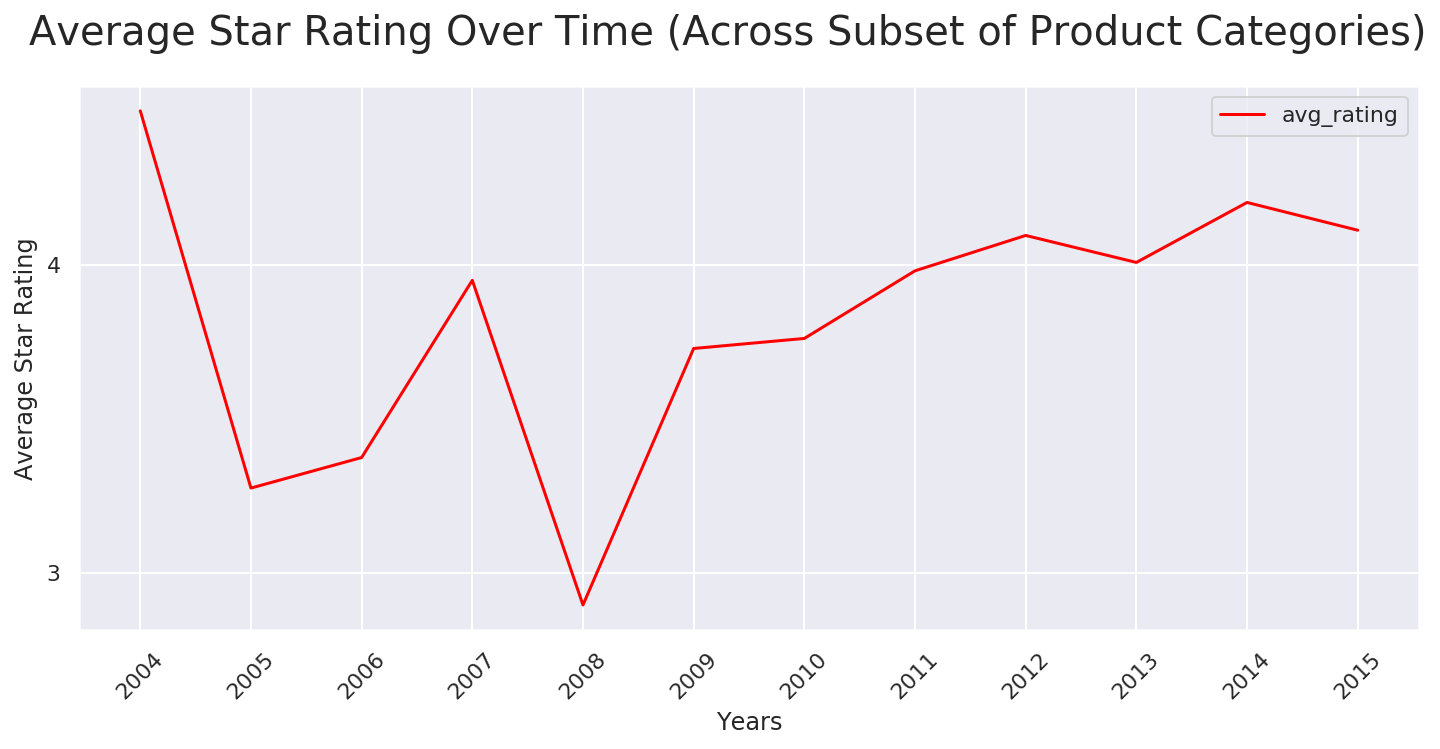

In [36]:
fig = plt.gcf()
fig.set_size_inches(12, 5)

fig.suptitle("Average Star Rating Over Time (Across Subset of Product Categories)")

ax = plt.gca()
# ax = plt.gca().set_xticks(df['year'])
ax.locator_params(integer=True)
ax.set_xticks(df["year"].unique())

df.plot(kind="line", x="year", y="avg_rating", color="red", ax=ax)

# plt.xticks(range(1995, 2016, 1))
# plt.yticks(range(0,6,1))
plt.xlabel("Years")
plt.ylabel("Average Star Rating")
plt.xticks(rotation=45)

# fig.savefig('average-rating.png', dpi=300)
plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-06.png"  width="90%" align="left">

## Average Star Rating Per Product Categories Across Time

In [37]:
# SQL statement
statement = """
    SELECT product_category, year, ROUND(AVG(star_rating), 4) AS avg_rating_category
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY product_category, year
    ORDER BY year 
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df


    SELECT product_category, year, ROUND(AVG(star_rating), 4) AS avg_rating_category
    FROM default.amazon_reviews_parquet
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY product_category, year
    ORDER BY year 



,product_category,year,avg_rating_category
0,Gift_Card,2004,4.5000
1,Gift_Card,2005,3.2759
2,Digital_Video_Games,2006,4.0000
3,Gift_Card,2006,3.2857
4,Gift_Card,2007,3.9500
5,Gift_Card,2008,3.3043
6,Digital_Software,2008,2.7333
7,Digital_Video_Games,2008,2.0000
8,Digital_Software,2009,2.7603
9,Digital_Video_Games,2009,3.8924


## Visualization

In [38]:
def plot_categories(df):
    df_categories = df["product_category"].unique()
    for category in df_categories:
        # print(category)
        df_plot = df.loc[df["product_category"] == category]
        df_plot.plot(
            kind="line",
            x="year",
            y="avg_rating_category",
            c=np.random.rand(
                3,
            ),
            ax=ax,
            label=category,
        )

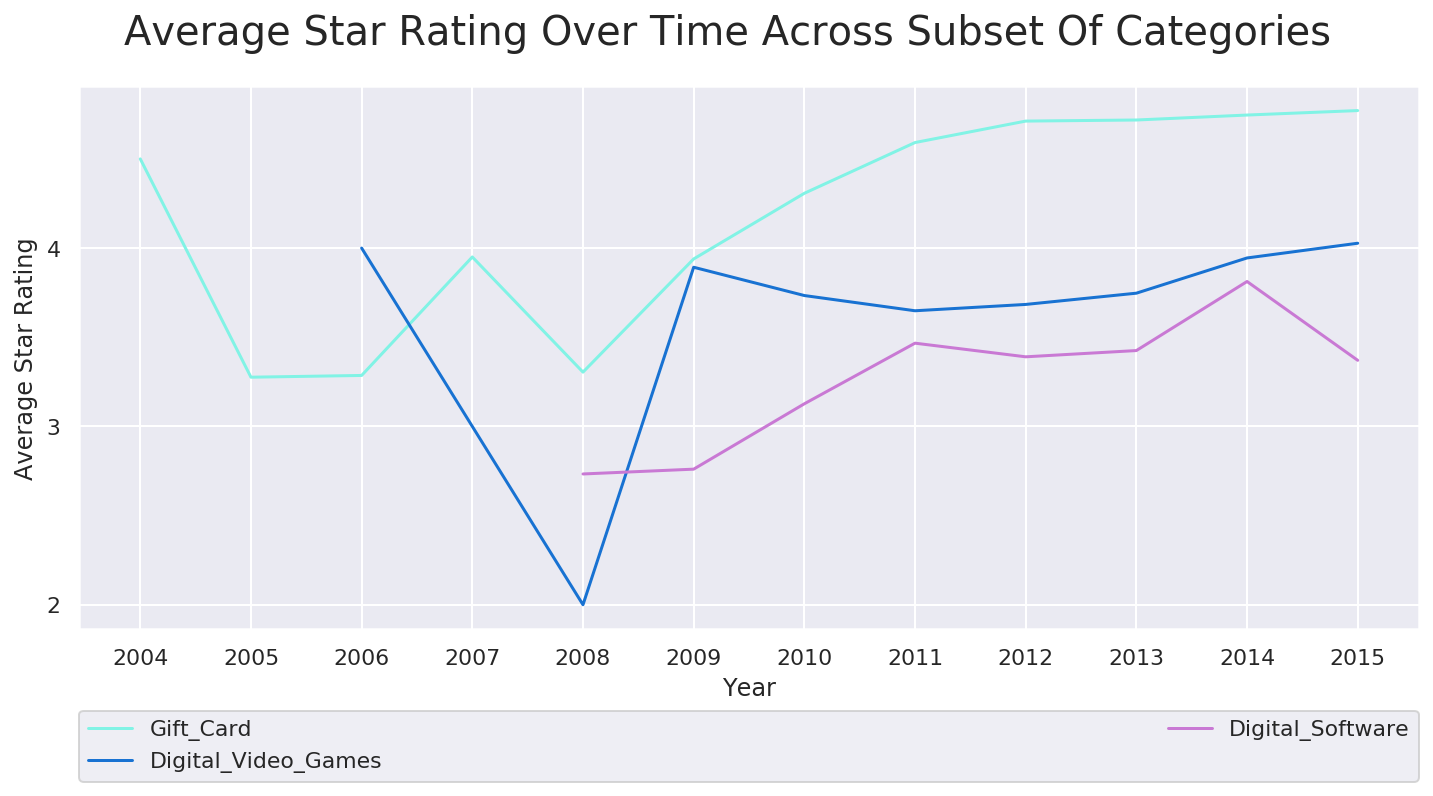

In [39]:
fig = plt.gcf()
fig.set_size_inches(12, 5)

fig.suptitle("Average Star Rating Over Time Across Subset Of Categories")

ax = plt.gca()

ax.locator_params(integer=True)
ax.set_xticks(df["year"].unique())

plot_categories(df)

plt.xlabel("Year")
plt.ylabel("Average Star Rating")
plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)

# fig.savefig('average_rating_category_all_data.png', dpi=300)
plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories, you would see the following visualization:

<img src="img/average_rating_category_all_data.png"  width="90%" align="left">

# 7. Which Star Ratings (1-5) are Most Helpful?

In [40]:
# SQL statement
statement = """
    SELECT star_rating, AVG(helpful_votes) AS avg_helpful_votes
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    GROUP BY  star_rating
    ORDER BY  star_rating ASC
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df


    SELECT star_rating, AVG(helpful_votes) AS avg_helpful_votes
    FROM default.amazon_reviews_parquet
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    GROUP BY  star_rating
    ORDER BY  star_rating ASC



,star_rating,avg_helpful_votes
0,1,4.890729
1,2,2.493028
2,3,1.559564
3,4,1.070936
4,5,0.532497


## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/star_rating_helpful_all.png"  width="25%" align="left">

## Visualization for a Subset of Product Categories

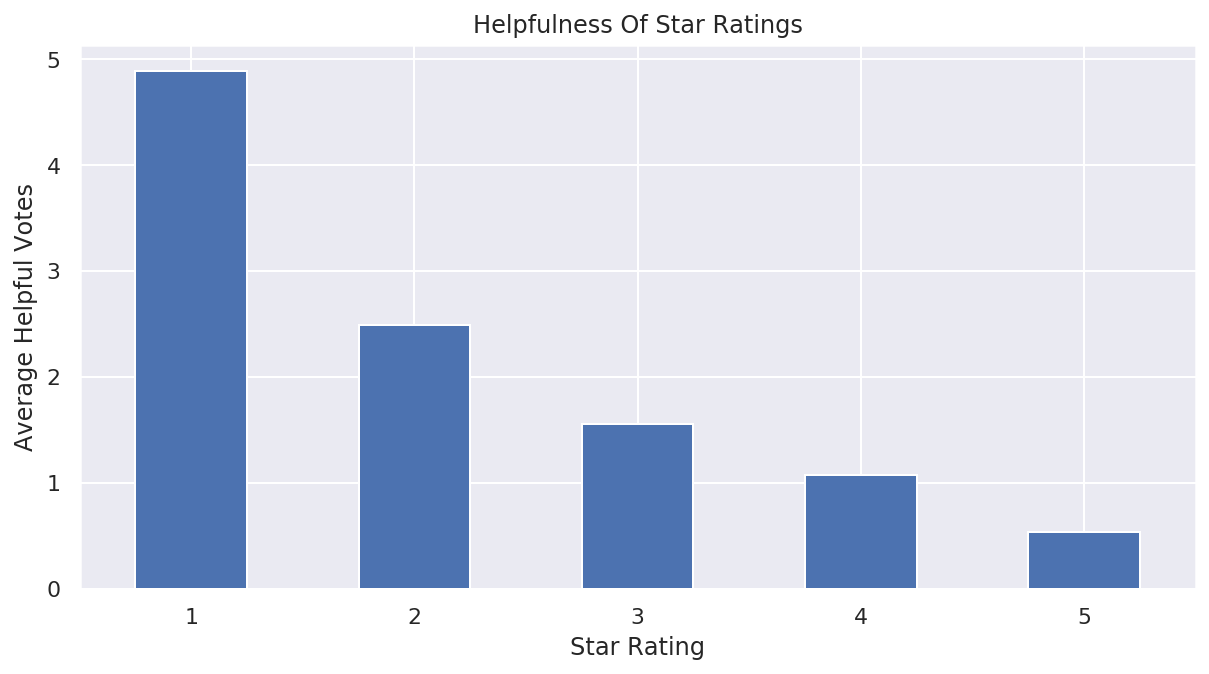

In [41]:
chart = df.plot.bar(
    x="star_rating", y="avg_helpful_votes", rot="0", figsize=(10, 5), title="Helpfulness Of Star Ratings", legend=False
)

plt.xlabel("Star Rating")
plt.ylabel("Average Helpful Votes")

plt.show(chart)

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-08.png"  width="70%" align="left">

# 8. Which Products have Most Helpful Reviews?  How Long are the Most Helpful Reviews?

In [42]:
# SQL statement
statement = """
    SELECT product_title, helpful_votes, star_rating,
           LENGTH(review_body) AS review_body_length,
           SUBSTR(review_body, 1, 100) AS review_body_substr
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    ORDER BY helpful_votes DESC LIMIT 10 
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df


    SELECT product_title, helpful_votes, star_rating,
           LENGTH(review_body) AS review_body_length,
           SUBSTR(review_body, 1, 100) AS review_body_substr
    FROM default.amazon_reviews_parquet
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    ORDER BY helpful_votes DESC LIMIT 10 



,product_title,helpful_votes,star_rating,review_body_length,review_body_substr
0,Amazon.com eGift Cards,5987,1,3498,"I think I am just wasting time writing this, b..."
1,TurboTax Deluxe Fed + Efile + State,5363,1,3696,I have been a loyal TurboTax customer since so...
2,SimCity - Limited Edition,5068,1,2478,Guess what? If you'd love to experience the no...
3,SimCity - Limited Edition,3789,1,1423,How would you feel if you waited for the new C...
4,Microsoft Office Home and Student 2013 (1PC/1U...,2955,1,4932,"I have never been a Microsoft hater, as many a..."
5,SimCity - Limited Edition,2509,5,1171,You'd think I'd be mega unhappy like everyone ...
6,TurboTax Deluxe Fed + Efile + State,2439,1,3710,Although a long time user of turbotax (satisfa...
7,Playstation Network Card,2384,5,190,$49.99 for $50 of credit? It's like getting a...
8,Amazon eGift Card - Smile,2383,4,463,I've used the gift cards many times and my chi...
9,Amazon eGift Card - Happy Birthday (Presents),2231,2,410,This is the second time I sent 2 gift cards. ...


## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/most_helpful_all.png"  width="90%" align="left">

# 9. What is the Ratio of Positive (5, 4) to Negative (3, 2 ,1) Reviews?

In [43]:
# SQL statement
statement = """
    SELECT (CAST(positive_review_count AS DOUBLE) / CAST(negative_review_count AS DOUBLE)) AS positive_to_negative_sentiment_ratio
    FROM (
      SELECT count(*) AS positive_review_count
      FROM {}.{}
      WHERE star_rating >= 4 and product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')

    ), (
      SELECT count(*) AS negative_review_count
      FROM {}.{}
      WHERE star_rating < 4 and product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    )
""".format(
    database_name, table_name, database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df


    SELECT (CAST(positive_review_count AS DOUBLE) / CAST(negative_review_count AS DOUBLE)) AS positive_to_negative_sentiment_ratio
    FROM (
      SELECT count(*) AS positive_review_count
      FROM default.amazon_reviews_parquet
      WHERE star_rating >= 4 and product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')

    ), (
      SELECT count(*) AS negative_review_count
      FROM default.amazon_reviews_parquet
      WHERE star_rating < 4 and product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    )



,positive_to_negative_sentiment_ratio
0,3.271554


## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/ratio_all.png"  width="25%" align="left">

# 10. Which Customers are Abusing the Review System by Repeatedly Reviewing the Same Product?  What Was Their Average Star Rating for Each Product?

In [44]:
# SQL statement
statement = """
    SELECT customer_id, product_category, product_title, 
    ROUND(AVG(star_rating),4) AS avg_star_rating, COUNT(*) AS review_count 
    FROM {}.{} 
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY customer_id, product_category, product_title 
    HAVING COUNT(*) > 1 
    ORDER BY review_count DESC
    LIMIT 5
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df


    SELECT customer_id, product_category, product_title, 
    ROUND(AVG(star_rating),4) AS avg_star_rating, COUNT(*) AS review_count 
    FROM default.amazon_reviews_parquet 
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY customer_id, product_category, product_title 
    HAVING COUNT(*) > 1 
    ORDER BY review_count DESC
    LIMIT 5



,customer_id,product_category,product_title,avg_star_rating,review_count
0,31012456,Digital_Video_Games,Call of Duty: Black Ops II - Personalization DLC,5.0,10
1,11421705,Digital_Video_Games,BioWare Points,5.0,8
2,23587418,Digital_Video_Games,BioWare Points,5.0,6
3,30754148,Digital_Video_Games,Sims 4,4.4,5
4,4934792,Digital_Video_Games,Grand Theft Auto V Cash Cards,1.0,4


## Result for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:
  
<img src="img/athena-abuse-all.png"  width="80%" align="left">

# 11. What is the distribution of review lengths (number of words)?

In [45]:
statement = """
    SELECT CARDINALITY(SPLIT(review_body, ' ')) as num_words
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df


    SELECT CARDINALITY(SPLIT(review_body, ' ')) as num_words
    FROM default.amazon_reviews_parquet
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')



,num_words
0,45.0
1,3.0
2,31.0
3,2.0
4,45.0
...,...
396596,83.0
396597,2.0
396598,13.0
396599,17.0


In [46]:
summary = df["num_words"].describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
summary

count    396598.000000
mean         51.683788
std         107.031158
min           1.000000
10%           2.000000
20%           7.000000
30%          19.000000
40%          22.000000
50%          26.000000
60%          32.000000
70%          43.000000
80%          63.000000
90%         110.000000
100%       5347.000000
max        5347.000000
Name: num_words, dtype: float64

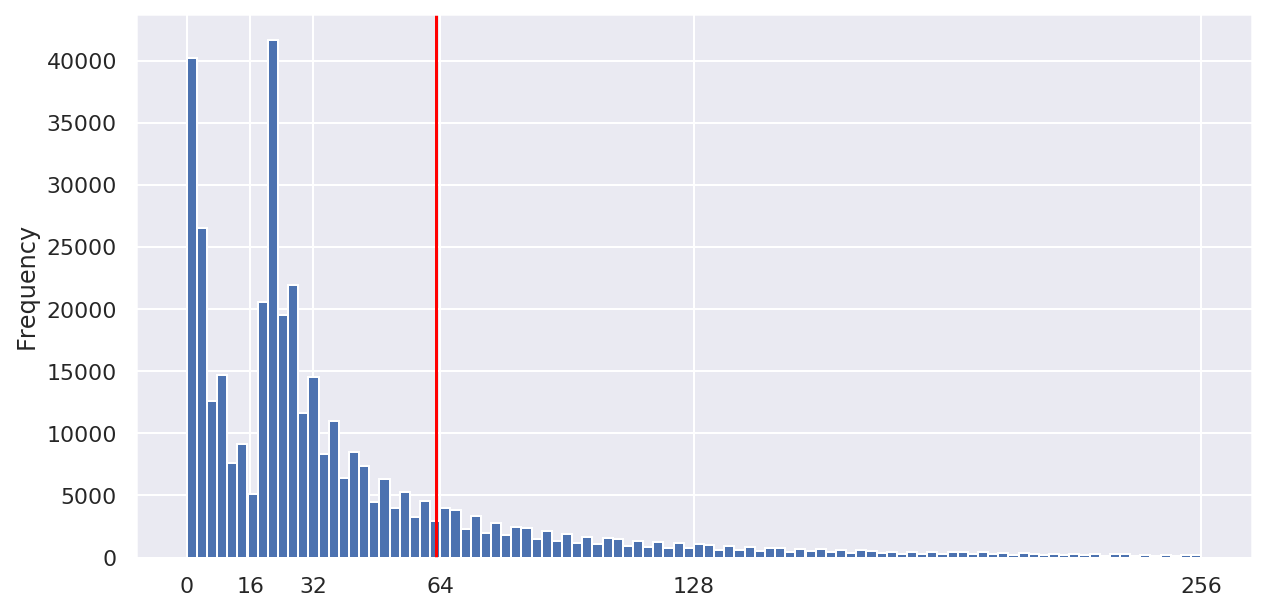

In [47]:
df["num_words"].plot.hist(xticks=[0, 16, 32, 64, 128, 256], bins=100, range=[0, 256]).axvline(
    x=summary["80%"], c="red"
)

# Release Resources

In [48]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>